# Подготовка данных

In [1]:
import xgboost as xgb
import catboost as cb
from catboost import CatBoostRegressor, cv, Pool, CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import pandas as pd, numpy as np, time
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from statistics import mean
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

In [2]:
test_data2 = pd.read_csv('test_data2.csv')
test_data3 = pd.read_csv('test_data3.csv')
test_data4 = pd.read_csv('test_data4.csv')
test_data5 = pd.read_csv('test_data5.csv')
test_data = pd.concat([test_data2, test_data3, test_data4, test_data5], axis=0)
test_data 

,Профиль,Длительность,H(md),L(md),Нефтенас.,Кр.пл(md),Абс.мощн.пласта,Абс.мощн.колл,Пор-ть,Проницаемость,Success,ГТМ
0,S-Shaped,5,2433.608000,1.008000,0.208800,2424.750000,14.070800,4.993600,0.112000,24.040400,0,ГРП
1,S-Shaped,5,2514.118519,0.900000,0.146296,2447.912222,115.969259,5.830741,0.109259,4.735926,0,ГРП
2,S-Shaped,2,2429.862500,1.450000,0.268750,2421.100000,18.949375,10.215000,0.131250,19.407500,0,ГРП
3,S-Shaped,5,2856.343750,1.162500,0.226250,2847.196250,14.277500,4.543750,0.111250,31.330625,1,ГРП
4,S-Shaped,8,2844.523529,1.294118,0.234706,2836.411765,14.107647,5.812353,0.124706,26.157059,1,ГРП
...,...,...,...,...,...,...,...,...,...,...,...,...
4,S-Shaped,7,2373.033333,1.470833,0.188750,2364.055000,19.954583,9.655833,0.131250,24.663750,0,Кислотная обработка
5,S-Shaped,5,2340.700000,1.587500,0.275625,2333.185000,13.880000,5.690000,0.136250,34.381875,0,Кислотная обработка
6,S/J-Shaped,5,3143.293333,0.720000,0.256000,3134.658000,16.382667,3.431333,0.108667,7.450000,1,Кислотная обработка
7,S-Shaped,51,2911.871429,0.950000,0.260714,2902.026429,20.241429,6.857143,0.103571,4.320714,1,Кислотная обработка


In [3]:
#df = pd.read_csv('df.csv', sep=',')
df=test_data 

In [4]:
# x_train3, x_test3, y_train3, y_test3 = train_test_split(df.drop(['Средний дебит', 'Q0', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5',
#        'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12','Score','Success','ГТМ'],  axis=1), df['Success'], test_size=0.999999, random_state=9)

### Анализ (Матрица корреляции)

<AxesSubplot: >

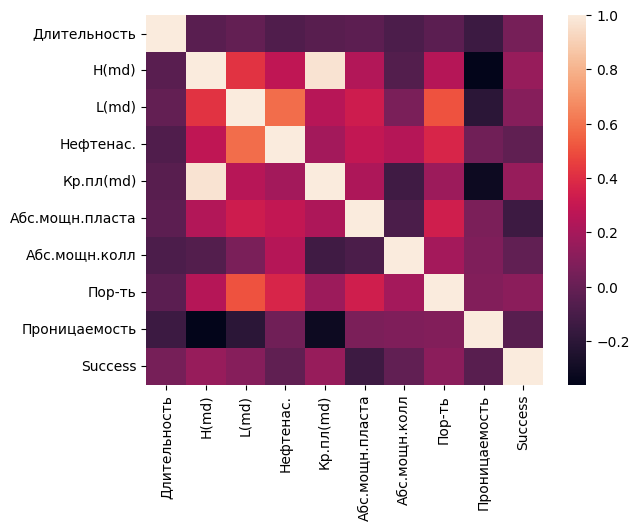

In [5]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=False)
# Выключили насос,дебит = 0. Включили, дебит =120 при тех же параметрах пласта. Вывод -> коррелировать и не должны. 
# По идее изменение дебита должно коррелировать с типом ГТМ.

In [6]:
def score_counting(gtm_df):   
    gtm_mean_q=gtm_df['Средний дебит'].mean()
    gtm_median_q=gtm_df['Средний дебит'].median()
    gtm_df['Score']=gtm_df['Средний дебит']/gtm_median_q
    gtm_df['Success'] = gtm_df.apply(lambda row: '1' if row['Score'] > 1 else '0', axis=1)
    gtm_df1=gtm_df.copy()
    return gtm_df,gtm_df1

In [7]:
# df, df_copy = score_counting(df)
# df

# Задача классификации для ГРП

In [8]:
df['ГТМ'] = df['ГТМ'].astype("category")
df['Success'] = df['Success'].astype("int")
df['Профиль'] = df['Профиль'].astype("category")
df['Длительность'] = df['Длительность'].astype("int")
df_full = df.copy() 
# df = df.drop(['ГТМ'],  axis=1)

In [9]:
from catboost import CatBoostRegressor, cv, Pool, CatBoostClassifier, sum_models, to_classifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import catboost as cb

In [10]:
# x_train3, x_test3, y_train3, y_test3 = train_test_split(df.drop(['Средний дебит', 'Q0', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5',
#        'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12','Score','Success','ГТМ'],  axis=1), df['Success'], test_size=0.999999, random_state=9)

In [11]:
x_test3=df.drop(['Success','ГТМ'],  axis=1)
y_test3 = df['Success']

In [12]:
# код для обединения моделей
models_list = []

model1 = CatBoostClassifier().load_model('catboost_model_GRP_0.73')
model2 = CatBoostClassifier().load_model('catboost_model_IS_GRP_0.69')
model3 = CatBoostClassifier().load_model('catboost_model_MS_GRP_1.0')
model4 = CatBoostClassifier().load_model('catboost_model_AT_df_0.8')

model1_list =[]
model2_list =[]
model3_list =[]
model4_list =[]

model1_list_proba =[]
model2_list_proba =[]
model3_list_proba =[]
model4_list_proba =[]
for index, row in x_test3.iterrows():
    # Extract the values as a NumPy array
    values = row.values
    
    # Apply each model to the array of values
    pred1 = model1.predict(values.reshape(1, -1))[0]
    pred2 = model2.predict(values.reshape(1, -1))[0]
    pred3 = model3.predict(values.reshape(1, -1))[0]
    pred4 = model4.predict(values.reshape(1, -1))[0]
    # Store the predicted class labels back into the row object
    model1_list.append(pred1)
    model2_list.append(pred2)
    model3_list.append(pred3)
    model4_list.append(pred4)
    
    proba1 = model1.predict_proba(values.reshape(1, -1))[0]
    proba2 = model2.predict_proba(values.reshape(1, -1))[0]
    proba3 = model3.predict_proba(values.reshape(1, -1))[0]
    proba4 = model4.predict_proba(values.reshape(1, -1))[0]
    
    model1_list_proba.append(max(proba1[0],proba1[1]))
    model2_list_proba.append(max(proba2[0],proba2[1]))
    model3_list_proba.append(max(proba3[0],proba3[1]))
    model4_list_proba.append(max(proba4[0],proba4[1]))
    
#     model1_list_proba.append(proba1)
#     model2_list_proba.append(proba2)
#     model3_list_proba.append(proba3)
#     model4_list_proba.append(proba4)
#     print(proba4, proba4[0], proba4[1], )

x_test3['GRP'] = model1_list
x_test3['GRP_proba'] = model1_list_proba

x_test3['IS_GRP'] = model2_list
x_test3['IS_GRP_proba'] = model2_list_proba

x_test3['MS_GRP'] = model3_list
x_test3['MS_GRP_proba'] = model3_list_proba

x_test3['AT_df'] = model4_list
x_test3['AT_df_proba'] = model4_list_proba


In [13]:
# model4_list_proba

In [14]:
# max_num = max(model4_list_proba)
# rounded_num = round(max_num, 2)
# print(rounded_num)


In [15]:
x_test3['ГТМ'] = df_full['ГТМ']

x_test3.rename(columns={'H(md)': 'H'}, inplace=True)
x_test3.rename(columns={'L(md)': 'L'}, inplace=True)
x_test3.rename(columns={'Kp(md)': 'Kp'}, inplace=True)
x_test3.rename(columns={'Длительность': 'Длит.'}, inplace=True)
x_test3['Success'] = df_full['Success']

In [16]:
# функция для получения значения из нужного столбца
def get_predict(row):
    if row['ГТМ'] == 'ГРП':
        return row['GRP']
    elif row['ГТМ'] == 'ГРП с изоляцией':
        return row['IS_GRP']
    elif row['ГТМ'] == 'Многостадийный ГРП':
        return row['MS_GRP']
    elif row['ГТМ'] == 'Кислотная обработка':
        return row['AT_df']
    else:
        return None

# применение функции к каждой строке DataFrame
x_test3['predict'] = x_test3.apply(get_predict, axis=1)

In [17]:
pd.set_option('display.max_rows', None)
x_test3

# Predict - Если в реальности на скважине проведен был, например, ГРП, то мы заносим в этот столбец наше предсказание
# по успешности ГРП. И этот столбец сравнивается с реальным критерием успешности из стоблца Success.

,Профиль,Длит.,H,L,Нефтенас.,Кр.пл(md),Абс.мощн.пласта,Абс.мощн.колл,Пор-ть,Проницаемость,...,GRP_proba,IS_GRP,IS_GRP_proba,MS_GRP,MS_GRP_proba,AT_df,AT_df_proba,ГТМ,Success,predict
0,S-Shaped,5,2433.608000,1.008000,0.208800,2424.750000,14.070800,4.993600,0.112000,24.040400,...,0.510843,1,0.780677,1,0.626337,0,0.577231,ГРП,0,0
1,S-Shaped,5,2514.118519,0.900000,0.146296,2447.912222,115.969259,5.830741,0.109259,4.735926,...,0.536792,1,0.698154,1,0.704013,0,0.517858,ГРП,0,1
2,S-Shaped,2,2429.862500,1.450000,0.268750,2421.100000,18.949375,10.215000,0.131250,19.407500,...,0.532901,1,0.678696,1,0.586314,1,0.647765,ГРП,0,1
3,S-Shaped,5,2856.343750,1.162500,0.226250,2847.196250,14.277500,4.543750,0.111250,31.330625,...,0.506681,1,0.551810,1,0.633073,0,0.546139,ГРП,1,1
4,S-Shaped,8,2844.523529,1.294118,0.234706,2836.411765,14.107647,5.812353,0.124706,26.157059,...,0.522525,0,0.599555,1,0.633073,0,0.634324,ГРП,1,1
5,S-Shaped,8,2584.766667,1.786667,0.336667,2577.149333,17.344000,8.500000,0.134000,25.012667,...,0.558624,0,0.697151,1,0.633073,0,0.987698,ГРП,1,1
6,S/J-Shaped,6,2997.454167,0.966667,0.307917,2989.591667,17.476250,7.534167,0.103333,7.534167,...,0.505713,0,0.559227,1,0.675267,0,0.981096,ГРП,0,0
7,J-Shaped,5,3298.384211,1.026316,0.268947,3278.347368,22.815789,5.040526,0.109474,5.768421,...,0.519290,1,0.513077,1,0.626898,1,0.982181,ГРП,0,0
8,S/J-Shaped,5,2346.542857,1.147619,0.273810,2339.991429,14.322381,6.002857,0.118571,29.626190,...,0.513464,1,0.682699,1,0.633073,0,0.525727,ГРП,0,0
9,S/J-Shaped,23,3438.023810,2.680952,0.194762,3424.883810,19.617143,10.315238,0.152381,15.648571,...,0.503159,0,0.534384,1,0.578118,1,0.599306,ГРП,0,0


In [25]:
x_test3['MS_GRP_proba'].mean()

0.6457466806024617

In [19]:
# Step 1
for index, row in x_test3.iterrows():
    # Step 2
    columns_with_one = []
    columns_with_only_zeros = []
    if row['GRP'] == 1:
        columns_with_one.append('GRP_proba')
    if row['IS_GRP'] == 1:
        columns_with_one.append('IS_GRP_proba')
    if row['MS_GRP'] == 1:
        columns_with_one.append('MS_GRP_proba')
    if row['AT_df'] == 1:
        columns_with_one.append('AT_df_proba')
    if (row['GRP'] == 0)&(row['IS_GRP'] == 0)&(row['MS_GRP'] == 0)&(row['AT_df'] == 0):
        columns_with_only_zeros.append('GRP_proba')
        columns_with_only_zeros.append('IS_GRP_proba')
        columns_with_only_zeros.append('MS_GRP_proba')
        columns_with_only_zeros.append('AT_df_proba')
  
    # Step 3
    max_proba_value = 0
    max_proba_column = ''
    min_proba_column = ''
    min_proba_value = 1
    
    if len(columns_with_one) > 0:
        for column in columns_with_one:
            if row[column] > max_proba_value:
                max_proba_value = row[column]
                max_proba_column = column
        max_proba_value = round(max_proba_value*100, 2)
    else:  
        for column in columns_with_only_zeros:
            if row[column] < min_proba_value:
                min_proba_value = row[column]
                min_proba_column = column
        min_proba_value=round((1-min_proba_value)*100, 2)
       
    # Step 4
    if max_proba_column == 'GRP_proba':
        result_text = 'ГРП.'
    elif max_proba_column == 'IS_GRP_proba':
        result_text = 'ГРП с изоляцией водопритока.'
    elif max_proba_column == 'MS_GRP_proba':
        result_text = 'многостадийного ГРП.'
    elif max_proba_column == 'AT_df_proba':
        result_text = 'кислотной обработки.'

      # Step 4
    if min_proba_column == 'GRP_proba':
        result_text1 = 'ГРП'
    elif min_proba_column == 'IS_GRP_proba':
        result_text1 = 'ГРП с изоляцией водопритока'
    elif min_proba_column == 'MS_GRP_proba':
        result_text1 = 'многостадийном ГРП'
    elif min_proba_column == 'AT_df_proba':
        result_text1 = 'кислотной обработки'      
        
#    print('d',max_proba_value)
    # Step 5
    if len(columns_with_only_zeros)!=0:
        print('Наибольшая вероятность успеха достигается при', result_text1,'c результатом в', min_proba_value, '%',)
    else:
        print('С вероятностью', max_proba_value, '% наиболее эффективным будет применение', result_text,)

С вероятностью 78.07 % наиболее эффективным будет применение ГРП с изоляцией водопритока.
С вероятностью 70.4 % наиболее эффективным будет применение многостадийного ГРП.
С вероятностью 67.87 % наиболее эффективным будет применение ГРП с изоляцией водопритока.
С вероятностью 63.31 % наиболее эффективным будет применение многостадийного ГРП.
С вероятностью 63.31 % наиболее эффективным будет применение многостадийного ГРП.
С вероятностью 63.31 % наиболее эффективным будет применение многостадийного ГРП.
С вероятностью 67.53 % наиболее эффективным будет применение многостадийного ГРП.
С вероятностью 98.22 % наиболее эффективным будет применение кислотной обработки.
С вероятностью 68.27 % наиболее эффективным будет применение ГРП с изоляцией водопритока.
С вероятностью 59.93 % наиболее эффективным будет применение кислотной обработки.
С вероятностью 62.63 % наиболее эффективным будет применение многостадийного ГРП.
С вероятностью 56.68 % наиболее эффективным будет применение многостадийног

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# calculate accuracy
accuracy1 = accuracy_score(y_test3, x_test3['predict'])
# accuracy2 = accuracy_score(y_test3, x_test3['predict'])
# accuracy3 = accuracy_score(y_test3, x_test3['predict'])
# accuracy4 = accuracy_score(y_test3, x_test3['predict'])
# calculate precision
# precision = precision_score(y_test3, pred3)
precision1 = precision_score(y_test3, x_test3['predict'])
# precision2 = precision_score(y_test3, x_test3['predict'])
# precision3 = precision_score(y_test3, x_test3['predict'])
# precision4 = precision_score(y_test3, x_test3['predict'])
# calculate recall
# recall = recall_score(y_test3, pred3)
recall1 = recall_score(y_test3, x_test3['predict'])
# recall2 = recall_score(y_test3, x_test3['predict'])
# recall3 = recall_score(y_test3, x_test3['predict'])
# recall4 = recall_score(y_test3, x_test3['predict'])

# calculate F1 score
# f1 = f1_score(y_test3, pred3)
f11 = f1_score(y_test3, x_test3['predict'])
# f12 = f1_score(y_test3, x_test3['predict'])
# f13 = f1_score(y_test3, x_test3['predict'])
# f14 = f1_score(y_test3, x_test3['predict'])


In [21]:
print("accuracy",'\n',accuracy1,
#       'GRP','\n',accuracy2,'IS_GRP','\n',accuracy3,'MS_GRP','\n',accuracy4,'AT_df',
     )

accuracy 
 0.7605633802816901


In [22]:
#те, сколько реально успешные среди угаданных успешных
print("precision",'\n',precision1,
#       'GRP','\n',precision2,'IS_GRP','\n',precision3,'MS_GRP','\n',precision4,'AT_df'
     )

precision 
 0.75


In [23]:
#процент успешных угаданных среди всех успешных
print("f1",'\n',f11
#       ,'GRP','\n',f12,'IS_GRP','\n',f13,'MS_GRP','\n',f14,'AT_df'
     )

f1 
 0.7792207792207791


<AxesSubplot: >

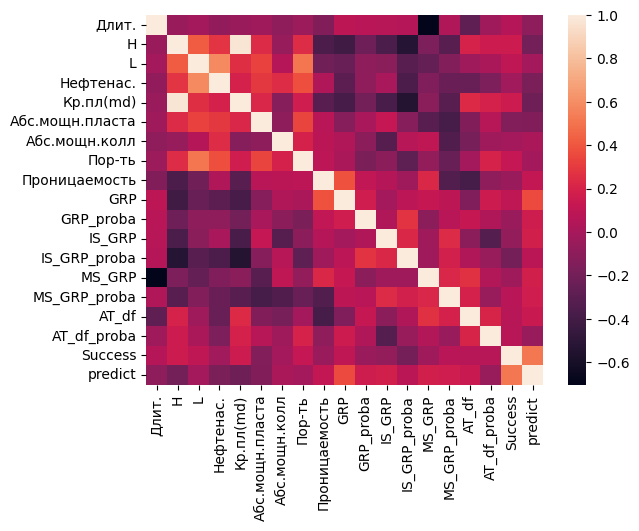

In [24]:
corr_matrix2 = x_test3.corr()
sns.heatmap(corr_matrix2, annot=False)